In [28]:
# импорт необходимых библиотек
import pandas as pd 
import sqlite3

import matplotlib.pyplot as plt
%matplotlib inline

# Проект: Анализ поведения клиентов интернет-магазина + RFM-анализ
## Цель проекта:
Изучить поведение клиентов интернет-магазина, сегментировать клиентов с помощью RFM-анализа и подготовить рекомендации для повышения выручки.

## Основные этапы:
Подготовка данных:

Загрузка и очистка данных из базы SQLite.

Проверка пропущенных значений, корректировка форматов дат.

Удаление дубликатов.

Проанализирована динамика заказов по месяцам.

Определены ТОП-10 товарных категорий и городов по количеству заказов.

## RFM-анализ клиентов:

Рассчитаны показатели:

Recency (давность последней покупки).

Frequency (количество заказов).

Monetary (суммарная выручка от клиента).

Проведена сегментация клиентов:

Champions — лучшие клиенты.

Loyal Customers — постоянные клиенты.

Potential Loyalists — потенциально лояльные клиенты.

At Risk — клиенты на грани ухода.

Hibernating — спящие клиенты.

In [ ]:
# Соединение с БД SQLite
conn = sqlite3.connect('olist.db')

# Загрузка CSV и создание таблиц
files = {
    'orders': 'olist_orders_dataset.csv', # Информация о заказах.
    'order_items': 'olist_order_items_dataset.csv', # Детали по товарам в заказах.
    'customers': 'olist_customers_dataset.csv', #  Данные покупателей.
    'products': 'olist_products_dataset.csv', # Информация о товарах.
    'payments': 'olist_order_payments_dataset.csv', # Данные о платежах.
    'reviews': 'olist_order_reviews_dataset.csv', # Отзывы покупателей.
    'geolocation': 'olist_geolocation_dataset.csv' # Геолокационные данные.
}

for table, file in files.items():
    df = pd.read_csv(file)
    df.to_sql(table, conn, if_exists='replace', index=False)
    print(f'{table} загружена в базу данных.')

conn.close()

## Шаг 1: Предварительная обработка данных и исследовательский анализ

In [2]:
# Загрузка данных
import pandas as pd

orders = pd.read_csv('olist_orders_dataset.csv', parse_dates = ['order_purchase_timestamp', 'order_approved_at', 
                                                                'order_delivered_carrier_date', 'order_delivered_customer_date', 
                                                                'order_estimated_delivery_date']) # Информация о заказах.
order_items = pd.read_csv('olist_order_items_dataset.csv', parse_dates = ['shipping_limit_date']) # Детали по товарам в заказах.
customers = pd.read_csv('olist_customers_dataset.csv') # Данные покупателей.
products = pd.read_csv('olist_products_dataset.csv') # Информация о товарах.
payments = pd.read_csv('olist_order_payments_dataset.csv') # Данные о платежах.
reviews = pd.read_csv('olist_order_reviews_dataset.csv', parse_dates=['review_creation_date', 'review_answer_timestamp']) # Отзывы покупателей.
geolocation = pd.read_csv('olist_geolocation_dataset.csv') # Геолокационные данные.

In [29]:
# проверка на наличие пропусков в  данных
orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [6]:
order_items.isnull().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [7]:
customers.isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [8]:
products.isnull().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [9]:
payments.isnull().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

In [16]:
reviews.isnull().sum() 

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [3]:
# функция для доступа к базе данных
def run_query(query, db_path='olist.db'):
    conn = sqlite3.connect(db_path) # Подключаемся к базе
    
    df = pd.read_sql_query(query, conn) # Выполняем запрос и забираем результат в DataFrame
    
    conn.close() # Закрываем соединение
    
    return df

#### Определим основные показатели из данных

In [69]:
# Средний чек

sql_query = """
SELECT AVG(total_price) AS avg_price
FROM 
(SELECT order_id, 
        SUM(price) AS total_price
FROM order_items
GROUP BY order_id) table_order
"""

# Выполняем запрос
result = run_query(sql_query)

# Смотрим результат
result

,avg_price
0,137.754076


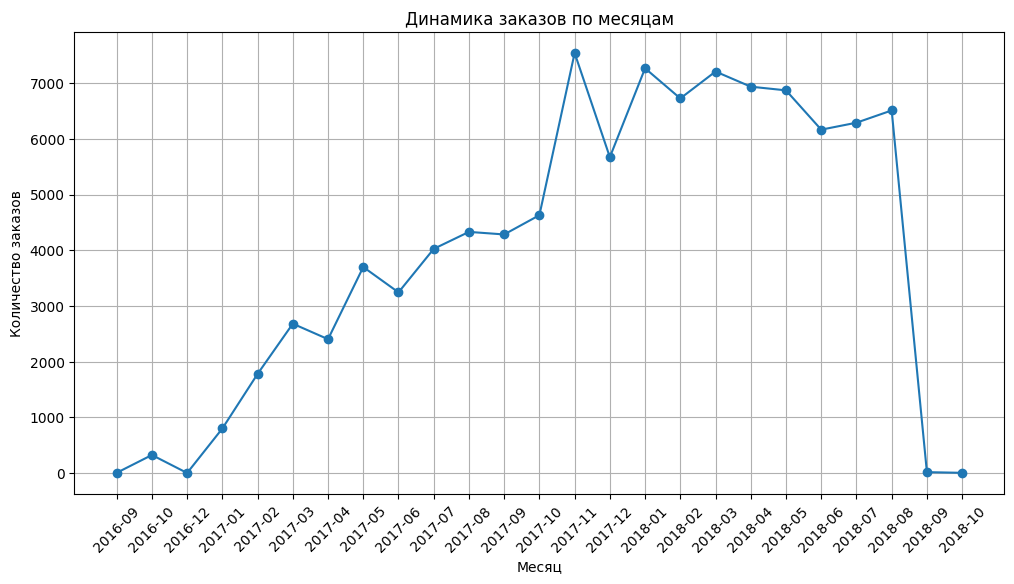

In [24]:
# Распределение заказов по датам и график

sql_query = """
SELECT 
    strftime('%Y-%m', order_purchase_timestamp) AS year_month,
    COUNT(order_id) AS count_orders    
FROM orders
GROUP BY year_month
ORDER BY year_month
"""

# Выполняем запрос
monthly_orders = run_query(sql_query)

# Смотрим результат
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(monthly_orders['year_month'], monthly_orders['count_orders'], marker='o')
plt.xticks(rotation=45)
plt.title('Динамика заказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.grid(True)
plt.show()

In [26]:
# топ 10 самых популярных категории
sql_query = """
SELECT 
    product_category_name,
    COUNT(order_id) AS items_sold
FROM order_items
LEFT JOIN products USING (product_id)
GROUP BY product_category_name
ORDER BY items_sold DESC
LIMIT 10
"""

# Выполняем запрос
top_10_category = run_query(sql_query)
top_10_category

,product_category_name,items_sold
0,cama_mesa_banho,11115
1,beleza_saude,9670
2,esporte_lazer,8641
3,moveis_decoracao,8334
4,informatica_acessorios,7827
5,utilidades_domesticas,6964
6,relogios_presentes,5991
7,telefonia,4545
8,ferramentas_jardim,4347
9,automotivo,4235


### Распределение по географии

In [6]:
# топ 10 популярных городов по количеству заказов
sql_query = """
SELECT 
    customer_city,
    COUNT(order_id) AS items_sold
FROM orders
LEFT JOIN customers USING (customer_id)
GROUP BY customer_city
ORDER BY items_sold DESC
LIMIT 10
"""

# Выполняем запрос
result = run_query(sql_query)
result

,customer_city,items_sold
0,sao paulo,15540
1,rio de janeiro,6882
2,belo horizonte,2773
3,brasilia,2131
4,curitiba,1521
5,campinas,1444
6,porto alegre,1379
7,salvador,1245
8,guarulhos,1189
9,sao bernardo do campo,938


## Шаг 2: Подготовка данных и RFM анализ

In [7]:
# для каждого пользователя определяем дату его последнего заказа, количество заказов, а также сумму каждого заказа

sql_query = """
SELECT 
    o.customer_id,
    MAX(o.order_purchase_timestamp) AS last_order_date,
    COUNT(o.order_id) AS total_orders,
    SUM(oi.price) AS total_spent
FROM orders AS o
LEFT JOIN order_items AS oi ON o.order_id = oi.order_id
GROUP BY o.customer_id
"""

# Выполняем запрос
rfm_table = run_query(sql_query)
rfm_table

,customer_id,last_order_date,total_orders,total_spent
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,1,89.80
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,1,54.90
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,1,179.99
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,1,149.90
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,1,93.00
...,...,...,...,...
99436,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,1,54.90
99437,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,1,47.90
99438,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,1,199.90
99439,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,2,21.80


In [8]:
# переведём колонку с датами в нужный формат для дальнейшей работы
rfm_table['last_order_date'] = pd.to_datetime(rfm_table['last_order_date'])

In [9]:
# определим дату от которой будет считать количество дней с последнего заказа

max_date = rfm_table['last_order_date'].max()
rfm_table['recency'] = (max_date - rfm_table['last_order_date']).dt.days

In [11]:
# оставим необходимые нам колонки, а также переименуем колонки для дальнейшего, удобного анализа

rfm_ready = rfm_table[['customer_id', 'recency', 'total_orders', 'total_spent']] \
            .rename(columns={'total_orders' : 'frequency', 'total_spent' : 'monetary'})

rfm_ready.head()

,customer_id,recency,frequency,monetary
0,00012a2ce6f8dcda20d059ce98491703,337,1,89.80
1,000161a058600d5901f007fab4c27140,458,1,54.90
2,0001fd6190edaaf884bcaf3d49edf079,596,1,179.99
3,0002414f95344307404f0ace7a26f1d5,427,1,149.90
4,000379cdec625522490c315e70c7a9fb,198,1,93.00


In [12]:
# Оставляем только нужные числовые колонки
rfm_numeric = rfm_ready[['recency', 'frequency', 'monetary']]

# Считаем квантили только по числовым признакам
quantiles = rfm_numeric.quantile(q=[0.25, 0.5, 0.75])
print(quantiles)

      recency  frequency  monetary
0.25    166.0        1.0      45.9
0.50    271.0        1.0      86.9
0.75    400.0        1.0     149.9


### Функция для распределния пользователей по сегментам

In [13]:
# Для Recency (меньше дней = лучше)
def r_score(x):
    if x <= quantiles['recency'][0.25]:
        return 4
    elif x <= quantiles['recency'][0.5]:
        return 3
    elif x <= quantiles['recency'][0.75]:
        return 2
    else:
        return 1

# Для Frequency (больше покупок = лучше)
def f_score(x):
    if x <= quantiles['frequency'][0.25]:
        return 1
    elif x <= quantiles['frequency'][0.5]:
        return 2
    elif x <= quantiles['frequency'][0.75]:
        return 3
    else:
        return 4

# Для Monetary (больше денег = лучше)
def m_score(x):
    if x <= quantiles['monetary'][0.25]:
        return 1
    elif x <= quantiles['monetary'][0.5]:
        return 2
    elif x <= quantiles['monetary'][0.75]:
        return 3
    else:
        return 4

In [14]:
# Вызов функции

rfm_ready['R'] = rfm_ready['recency'].apply(r_score)
rfm_ready['F'] = rfm_ready['frequency'].apply(f_score)
rfm_ready['M'] = rfm_ready['monetary'].apply(m_score)

In [15]:
# Соединяем три цифры в одну последовательность
rfm_ready['RFM_Score'] = rfm_ready['R'].astype(str) + rfm_ready['F'].astype(str) + rfm_ready['M'].astype(str)

rfm_ready.head()

,customer_id,recency,frequency,monetary,R,F,M,RFM_Score
0,00012a2ce6f8dcda20d059ce98491703,337,1,89.80,2,1,3,213
1,000161a058600d5901f007fab4c27140,458,1,54.90,1,1,2,112
2,0001fd6190edaaf884bcaf3d49edf079,596,1,179.99,1,1,4,114
3,0002414f95344307404f0ace7a26f1d5,427,1,149.90,1,1,3,113
4,000379cdec625522490c315e70c7a9fb,198,1,93.00,3,1,3,313


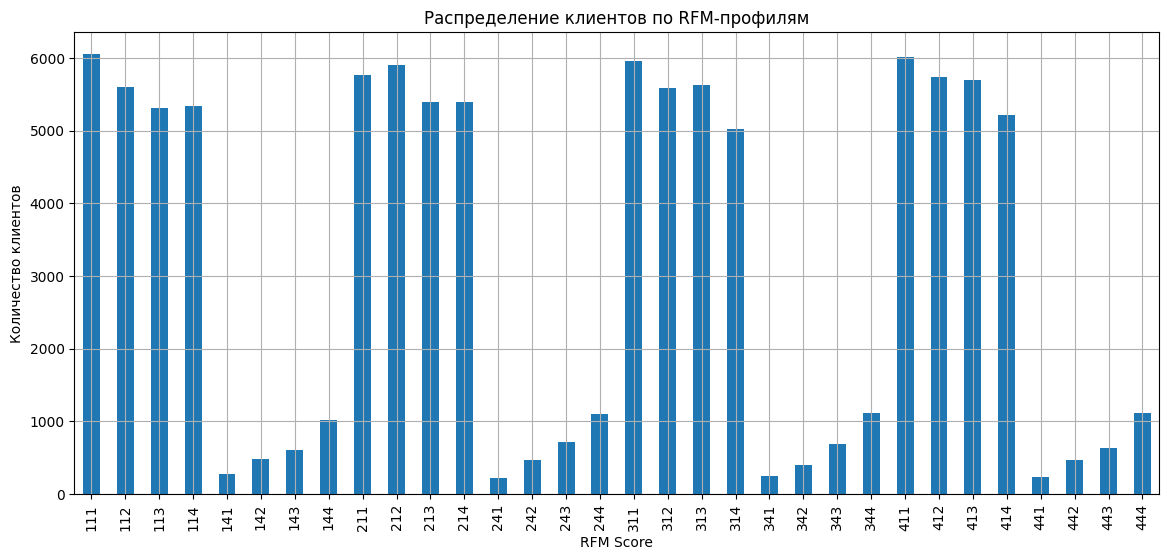

In [16]:
# Считаем количество клиентов в каждой группе
rfm_ready['RFM_Score'].value_counts().sort_index().plot(kind='bar', figsize=(14,6))

# Строим график распределения по RFM сегментам
plt.title('Распределение клиентов по RFM-профилям')
plt.xlabel('RFM Score')
plt.ylabel('Количество клиентов')
plt.grid(True)
plt.show()


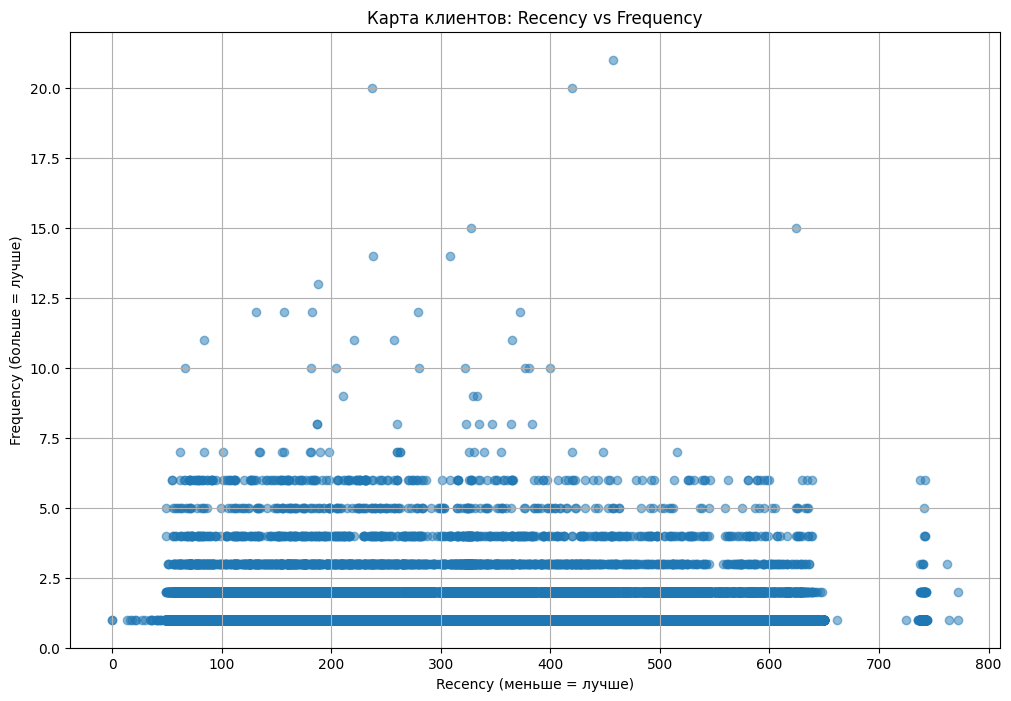

In [17]:
# Построим график Recency vs Frequency
plt.figure(figsize=(12, 8))
plt.scatter(rfm_ready['recency'], rfm_ready['frequency'], alpha=0.5)

# Оси
plt.title('Карта клиентов: Recency vs Frequency')
plt.xlabel('Recency (меньше = лучше)')
plt.ylabel('Frequency (больше = лучше)')
plt.grid(True)
plt.show()

### Сегментация клиентов по RFM

In [18]:
# Дополнительно просегментируем пользователей на группы

def segment_customer(row):
    if row['R'] == 4 and row['F'] == 4:
        return 'Champion'
    elif row['R'] >= 3 and row['F'] >= 3:
        return 'Loyal Customer'
    elif row['R'] >= 3 and row['F'] == 2:
        return 'Potential Loyalist'
    elif row['R'] == 2:
        return 'At Risk'
    else:
        return 'Hibernating'

# Применяем функцию
rfm_ready['segment'] = rfm_ready.apply(segment_customer, axis=1)

# Смотрим примеры
rfm_ready[['customer_id', 'R', 'F', 'M', 'RFM_Score', 'segment']].head()

,customer_id,R,F,M,RFM_Score,segment
0,00012a2ce6f8dcda20d059ce98491703,2,1,3,213,At Risk
1,000161a058600d5901f007fab4c27140,1,1,2,112,Hibernating
2,0001fd6190edaaf884bcaf3d49edf079,1,1,4,114,Hibernating
3,0002414f95344307404f0ace7a26f1d5,1,1,3,113,Hibernating
4,000379cdec625522490c315e70c7a9fb,3,1,3,313,Hibernating


In [32]:
# процентное распределение по сегментам
rfm_ready.segment.value_counts(normalize=True)

segment
Hibernating       0.699571
At Risk           0.250983
Loyal Customer    0.024738
Champion          0.024708
Name: proportion, dtype: float64

In [34]:
rfm_ready.groupby('segment', as_index=False)['monetary'].sum()

,segment,monetary
0,At Risk,3382450.25
1,Champion,529018.19
2,Hibernating,9200401.24
3,Loyal Customer,479774.02


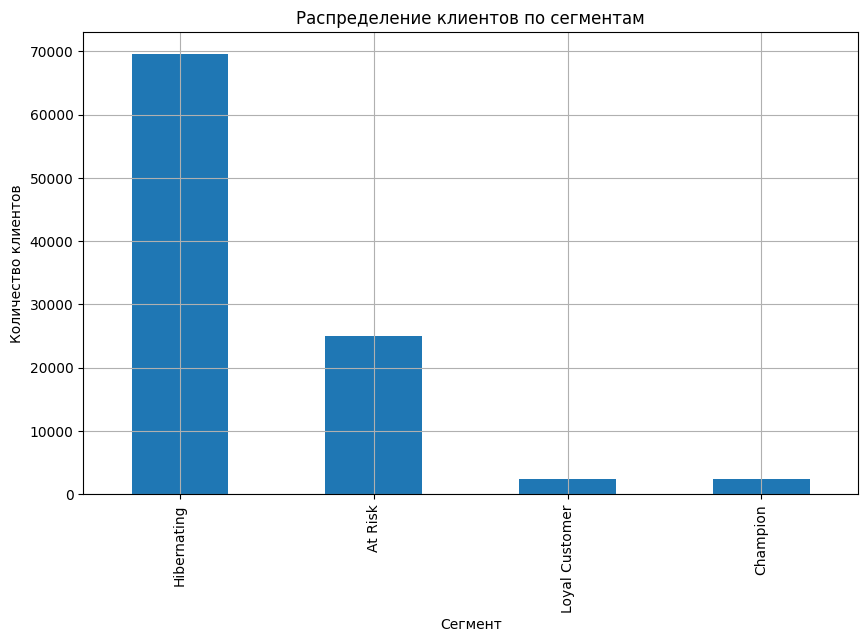

In [19]:
plt.figure(figsize=(10, 6))
rfm_ready['segment'].value_counts().plot(kind='bar')
plt.title('Распределение клиентов по сегментам')
plt.xlabel('Сегмент')
plt.ylabel('Количество клиентов')
plt.grid(True)
plt.show()

## Итоги: 

Почти 70% клиентов находятся в сегменте Hibernating (давно не покупали), но при этом они всё ещё составляют наибольшую часть выручки.

Сегмент At Risk — 25% клиентов, важная зона для удержания.

Самые ценные клиенты по поведению — Champions, их всего 2.5%, но они приносят значимый вклад (~530 тыс).

Loyal Customers также 2.5%, и это стабильный сегмент, который можно развивать через персонализированные предложения.